**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

The second package we are installing is [pymatsolver](https://github.com/rowanc1/pymatsolver), which interfaces to sparse matrix solvers. It is not required for the tutorial, we will fall-back to an LU solver, which is sufficient for this problem 

In [1]:
# !pip install SimPEG
# !pip install pymatsolver

# Inversion: 1D Magnetotelluric Problem

In the previous notebooks, we explored how to discretize the [1D MT problem](./1_MT1D_NumericalSetup.ipynb), how to design an appropriate mesh, and explored the [an example of non-uniquness](./2_MT1D_ForwardModellingAndNonuniqueness.ipynb). In this notebook, we will put those concepts to use and set up a 1D inversion. 

The aim of this notebook is to highlight the elements we use to set up and solve the inverse problem, in the notebook that follows this, we will dive futher into the impact of various parameter choices (eg. the trade-off parameter $\beta$, the stopping criteria, noise model and regulariztion parameters). 

## Inversion as Optimization

We will use deterministic approach and pose the inverse problem as an optimization problem of the form 

$$
\min_{\mathbf{m}} \phi(\mathbf{m}) = \phi_d(\mathbf{m}) + \beta\phi_m(\mathbf{m})
$$

where:
- $\mathbf{m}$ is our model - the vector of numbers that describes our earth model. It is what we are solving for in the inversion
- $\phi_d(\mathbf{m})$ is the data misfit
- $\phi_m(\mathbf{m})$ is the regularization
- $\beta$ is a trade-off parameter

### Data Misfit

The data misfit, $\phi_d(\mathbf{m})$, is often taken to be a weighted $\ell_2$-norm, where the weights capture the noise model (eg. we want to assign higher weights and do a good job fitting data that we are confident are less noisy, and assign less weight / influence to data that are noisy). The $\ell_2$ norm is the correct norm to choose when noise is Gaussian (or approximately Gaussian, or if you have no additional information and assume it is Gaussian). An $\ell_2$ data misfit is captured mathematically by  

$$
\phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) - \mathbf{d}^{\text{obs}})\|^2
$$

where 

- $\mathbf{W_d} = \text{diag}(1/\boldsymbol{\epsilon})$ is a diagonal matrix with diagonal entries $1/\epsilon_i$, where $\epsilon_i$ is an estimated standard deviation of the $i$th datum.
- $\mathcal{F}$ is the forward modelling operator that simulates the 1D MT response given a model
- $\mathbf{m}$ is the model: the set of parameters which describe the physical properties of the layered earth
- $\mathbf{d}^{\text{obs}}$ is the observed data

(The factor of $1/2$ and the choice of using the squared-norm is a matter of convienence. We will be using gradient based optimzation methods, so it is easier to take derivatives of a norm squared than a norm.)

### Regularization
The inverse problem is an [ill posed problem](https://en.wikipedia.org/wiki/Well-posed_problem). There are multiple (actually infinitely many!) models that can fit the data.  There are a couple ways to observe this:

- Mathematically: If we start by thinking about a linear problem $\mathbf{G}\mathbf{m} = \mathbf{d}$, the matrix $\mathbf{G}$ is wide, so it is not directly invertible (eg. see Matt Hall's [Linear Inversion Tutorial](http://library.seg.org/doi/full/10.1190/tle35121085.1)). Here, we are dealing with a non-linear system of equations, but the principle is the same. 

- An Example: In the [Forward Modelling and Nonuniqueness notebook](2_MT1D_ForwardModellingAndNonuniqueness.ipynb), we used forward modelling to demonstrate non-uniquness with the conductivity-thickness product of a single, conductive layer, and this is a very simple model compared to most geologic settings! 

Thus, to choose from the infinitely many solutions and arrive at a sensible one, we employ a regularization: $\phi_m$. Tikhonov regularization, which again employs $\ell_2$-norms, is a standard choice (It has a few nice features: it is convex and easy to differentiate). It takes the form: 
$$
\phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|\mathbf{W_s} (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_z\|\mathbf{W_z} (\mathbf{m})\|^2 \big)
$$

The first term is often referred to as the "smallness" as it measures the "size" of the model (in the $\ell_2$ sense). The matrix $\mathbf{W_s}$ is generally taken to be a diagonal matrix that may contain information about the length scales of the model or be used to weight the relative importance of various parameters in the model. The scalar $\alpha_s$ weights the relative importance of this term in the regularization. Notice that we include a reference model ($\mathbf{m}_{\text{ref}}$. Often this is defined as a constant value, but if more information is known about the background, that can be used to construct a reference model. Note that saying "I am not going to use a reference model" means that you are actually using $\mathbf{m}_{\text{ref}} = 0$, this is important to realize... in the inversion we demonstrate here, our `model` will be $\mathbf{m} = \text{log}(\sigma)$. If we set $\mathbf{m}_{\text{ref}} = 0$, then we are favoring models close to 1 S/m - which is quite conductive! 

The second term is often referred to as the "smoothness". The matrix $\mathbf{W_z}$ approximate the derivative of the model with respect to depth, and is hense a measure of how "smooth" the model is. The term $\alpha_z$ weights its relative importance in the regularization. 


## In this notebook...

Although we pose the inverse problem as an optimization problem, we aren't necessarily going to solve to a true minimum. There are always uncertainties with the data, so there is no point trying to drive $\phi_d$ to its true minimium - we would end up introducing structures in the model to fit the data (we will explore this here). So another choice that has to be made when setting up an inversion is where to stop. 

In this notebook, we will walk through how to set up an inversion and discuss one of the knobs:
- The $\beta$ knob: How well should we fit the data verses the regularization? Which $\beta$ value provides us the right balance? eg. When do we achieve the target misfit $\phi_d^*$?
- The $\alpha$ knob: Tuning the **regularization** ($\alpha_s$, $\alpha_z$): how _smooth_ or _small_ (in the $\ell_2$-sense) do we want our model to be?

We will also point out other parameters you can explore the impact of, including, 
- starting model $\mathbf{m}_0$
- reference model $\mathbf{m}_{\text{ref}}$
- designing a $\beta$-cooling schedule

In the [next notebook](./4_MT1D_5layer_inversion.ipynb) we will dive further into the $\alpha$ knob. 

**A Note**

We will employ second-order optimization methods, meaning we have to be able to both simulate data and compute derivatives. We will take those steps for granted in this notebook, but if you are curious to look under the hood and see how sensitivities are computed for this problem, have a look at the [Sensitivities Notebook](./Appendix_A_MT1D_Sensitivity.ipynb).  

In [2]:
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import (
    Mesh, Maps, SolverLU, DataMisfit, Regularization,
    Optimization, InvProblem, Inversion, Directives, Utils
)

try:
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as Solver
    
from MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
%matplotlib inline

## Forward Simulation

### Parmeters
Now, we define our model parameters and survey setup. This includes defining
- location of receivers
- frequencies we are sampling
- type of dat we are measuring (impedance or apparent resistivity and phase)

Similar to the model shown in [1_MT1D_NumericalSetup.ipynb](./1_MT1D_NumericalSetup.ipynb) and [2_MT1D_ForwardModellingAndNonuniqueness](./2_MT1D_ForwardModellingAndNonuniqueness.ipynb). We will consider a model which consists of 5 units: 

In [ ]:
d0, d1, d2, d3, d4 = 0., 600., 1991., 5786., 9786.
rho0, rho1, rho2, rho3, rho4 = 250., 25, 100., 10., 25
d = [d1, d2, d3, d4]
rho = [rho1, rho2, rho3, rho4]

layer_inds0 = np.logical_and(mesh.vectorCCx<-d0, mesh.vectorCCx>-d1)
layer_inds1 = np.logical_and(mesh.vectorCCx<-d1, mesh.vectorCCx>-d2)
layer_inds2 = np.logical_and(mesh.vectorCCx<-d2, mesh.vectorCCx>-d3)
layer_inds3 = np.logical_and(mesh.vectorCCx<-d3, mesh.vectorCCx>-d4)
layer_inds4 = mesh.vectorCCx<-d4

sigma = np.ones(mesh.nC) * np.nan
sigma[layer_inds0] = 1./rho0
sigma[layer_inds1] = 1./rho1
sigma[layer_inds2] = 1./rho2
sigma[layer_inds3] = 1./rho3
sigma[layer_inds4] = 1./rho4


In [3]:
rxloc = np.r_[0.]
srcloc = np.r_[0.]

frequency = np.logspace(-3, 2, 25)
rxType = "Zxy"
if rxType == "Zxy":
    rx = ZxyRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
elif rxType == "AppredPha":
    rx = AppResPhaRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
src = MT1DSrc(rxList, loc=srcloc)
survey = MT1DSurvey([src])
max_depth_core = 15000.
mesh = survey.setMesh(
        sigma=0.01, max_depth_core=max_depth_core, ncell_per_skind=10, n_skind=2,
        core_meshType = "log", max_hz_core=1000.
                     )
sigma = np.ones(mesh.nC) * 0.001
prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), verbose=False, Solver=Solver)
prob.pair(survey)

>> Smallest cell size = 50 m
>> Padding distance = 316227 m
>> # of padding cells 17
>> # of core cells cells 47


In [4]:
def appres_phase_from_Zxy(pred, frequency):
    Zr = pred.reshape((survey.nFreq, 2))[:,0]
    Zi = pred.reshape((survey.nFreq, 2))[:,1]
    Z = Zr + 1j*Zi
    omega = frequency * 2 * np.pi
    appres = abs(Z)**2 / (mu_0*omega) 
    phase = np.rad2deg(np.arctan(Z.imag / Z.real))
    return appres, phase

In [5]:
def Zxy_from_appres_phase(zabs, phase, frequency):
    Z = zabs * np.exp(1j*np.deg2rad(phase))
    return np.c_[Z.real, Z.imag].flatten()

In [6]:

actinds = mesh.vectorCCx > -max_depth_core

mtrue = np.log(sigma)
dtrue = survey.dpred(mtrue)
np.random.seed(1)

std = 0.1
# zr = dtrue.reshape((survey.nFreq, 2))[:,0]
# zi = dtrue.reshape((survey.nFreq, 2))[:,1]
# uncert_appres = abs(zr + 1j*zi)*std
# uncert_phase = np.ones(survey.nFreq)*floor
# uncert  = Zxy_from_appres_phase(uncert_appres, uncert_phase, frequency)
uncert = abs(dtrue) * std
noise = uncert * np.random.randn(survey.nFreq*2)
survey.dobs = dtrue + noise

In [7]:
app_res, phase = appres_phase_from_Zxy(survey.dobs, frequency)

In [8]:
app_res_true, phase_true = appres_phase_from_Zxy(dtrue, frequency)

(25.000000000232831, 30000.0)

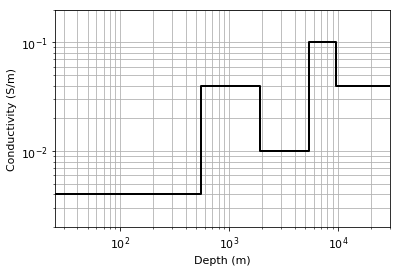

In [9]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
# figsize(5, 2)
sigtrue = np.repeat(sigma, 2, axis=0)
z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
plt.plot(-z, sigtrue, 'k', lw=2)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Conductivity (S/m)")
plt.xlabel("Depth (m)")
plt.grid(True, which='both')
plt.ylim(2e-3, 2e-1)
plt.xlim(0, max_depth_core*2.)

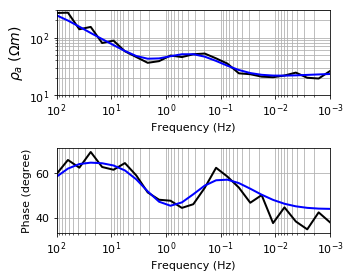

In [10]:
fig = plt.figure(figsize = (5, 4))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.loglog(frequency, app_res, 'k-', lw=2)
ax1.loglog(frequency, app_res_true, 'b-', lw=2)
ax1.grid(True, which='both')
ax1.set_xlim(frequency.max(), frequency.min())
ax1.set_ylim(10, 3e2)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

ax2.semilogx(frequency, phase, 'k-', lw=2)
ax2.semilogx(frequency, phase_true, 'b-', lw=2)
ax2.grid(True, which='both')
ax2.set_xlim(frequency.max(), frequency.min())
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Phase (degree)")
plt.tight_layout()

In [11]:
def run_MT1Dinv(prob, survey, m0,
                std_appres=0.05, floor_phase =2.,
                alpha_s=1., alpha_x=1., coolingFactor=2., coolingRate=1, 
                beta0=1e1, beta0_ratio=None,
                use_betaest=False, use_target=True):
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    reg = Regularization.Simple(prob.mesh, alpha_s=alpha_s, alpha_x=alpha_x)
    opt = Optimization.InexactGaussNewton(maxIter=35, LSshorten=0.5)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    # Create an inversion object
    beta = Directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    invProb.beta = beta0
    target = Directives.TargetMisfit()
    save = Directives.SaveOutputEveryIteration()
    directs = [beta, save]

    if use_target:
        directs.append(target)
    if use_betaest:
        if beta0_ratio is None:
            beta0_ratio = 1.
        betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
        directs.append(betaest)      
        
    inv = Inversion.BaseInversion(invProb, directiveList=directs)
    prob.counter = opt.counter = Utils.Counter()
    opt.remember('xc')
    mopt = inv.run(m0)
    xc = opt.recall("xc")
    return xc, save, reg


In [25]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc, save, reg = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=8, coolingRate=3,
                                   alpha_s=1e-2, alpha_x=1.,
                                   beta0_ratio=10.,
                                   use_betaest=True,
                                   use_target=False)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-24-18-41.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.70e+02  1.72e+03  0.00e+00  1.72e+03    4.89e+02      0              
   1  6.47e+02  2.86e+02  2.09e-01  4.22e+02    6.10e+01      0              
   2  4.31e+02  1.64e+02  3.29e-01  3.06e+02    2.25e+01      0   Skip BFGS  
   3  2.87e+02  1.24e+02  4.03e-01  2.40e+02    1.84e+01      0   Skip BFGS  
   4  1.92e+02  9.26e+01  4.91e-01  1

In [26]:
save.load_results()

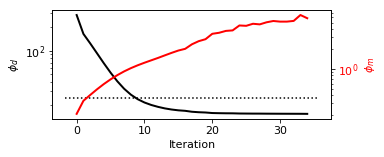

In [27]:
save.plot_misfit_curves(plot_small_smooth=False)

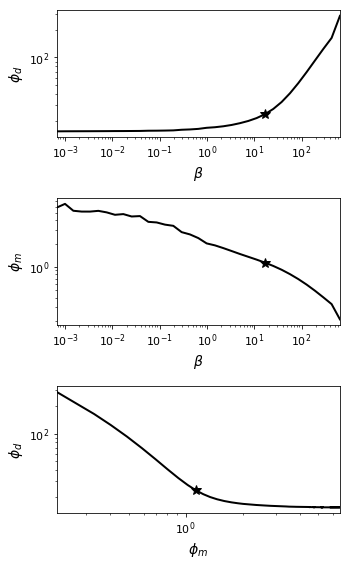

In [28]:
save.plot_tikhonov_curves()

In [16]:
save.i_target

13

In [29]:
from ipywidgets import interact, IntSlider, ToggleButtons
def view_1Dinversion_results(iteration, scale, save):
    fig = plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.loglog(save.phi_m, save.phi_d, 'k-', lw=2)
    if save.i_target is not None:
        ax1.loglog(save.phi_m[save.i_target], save.phi_d[save.i_target], 'k*', ms=10)
    ax1.loglog(save.phi_m[iteration], save.phi_d[iteration], 'ro', ms=10)
    ax1.set_xlim(save.phi_m.min(), save.phi_m.max())
    ax1.set_xlabel("$\phi_m$", fontsize = 14)
    ax1.set_ylabel("$\phi_d$", fontsize = 14)
    ax1.set_xscale(scale)
    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax3.plot(-z, sigtrue, 'k', lw=2)
    ax3.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax3.set_xscale("log")
    ax3.set_yscale("log")
    ax3.set_ylabel("Conductivity (S/m)")
    ax3.set_xlabel("Depth (m)")
    ax3.grid(True, which='both')
    ax3.set_ylim(2e-3, 2e-1)
    ax3.set_xlim((-z).min(), (-z).max())
    dpred = survey.dpred(xc[iteration])
    app_res_pred, phase_pred = appres_phase_from_Zxy(dpred, frequency)
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax4.semilogx(frequency, phase, 'k-', lw=2)
    ax4.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax4.grid(True, which='both')
    ax4.set_xlim(frequency.max(), frequency.min())
    ax4.set_xlabel("Frequency (Hz)")
    ax4.set_ylabel("Phase (degree)")
    plt.tight_layout()
    plt.show()

def foo(iteration, scale):
    return view_1Dinversion_results(iteration, scale, save)
interact(foo, 
         iteration=IntSlider(min=0, max=save.phi_d.shape[0]-1, step=1, value=0),
         scale=ToggleButtons(options=["linear", "log"], value="log"))

<function __main__.foo>

In [18]:
def MT1D_inv_results(xc, iteration):
    fig = plt.figure(figsize = (5, 7))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax1.plot(-z, sigtrue, 'k', lw=2)
    ax1.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_ylabel("Conductivity (S/m)")
    ax1.set_xlabel("Depth (m)")
    ax1.grid(True, which='both')
    ax1.set_ylim(2e-3, 4e-1)
    ax1.set_xlim((-z).min(), (-z).max())

    dpred = survey.dpred(xc[iteration])
    app_res_pred, phase_pred = appres_phase_from_Zxy(dpred, frequency)
    
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax3.semilogx(frequency, phase, 'k-', lw=2)
    ax3.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax3.grid(True, which='both')
    ax3.set_xlim(frequency.max(), frequency.min())
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)
    plt.tight_layout()

In [19]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_smooth, save_smooth, reg_smooth = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=8, coolingRate=3,
                                   alpha_s=1e-5, alpha_x=1.,
                                   beta0_ratio=1.,
                                   use_betaest=True,
                                   use_target=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-24-18-38.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.96e+01  1.72e+03  0.00e+00  1.72e+03    4.89e+02      0              
   1  4.64e+01  1.89e+02  3.06e-02  1.91e+02    7.29e+01      0              
   2  3.09e+01  4.33e+01  4.70e-01  5.79e+01    2.01e+01      0   Skip BFGS  
   3  2.06e+01  2.56e+01  5.99e-01  3.79e+01    4.63e+00      0              
------------------------- STOP! -----

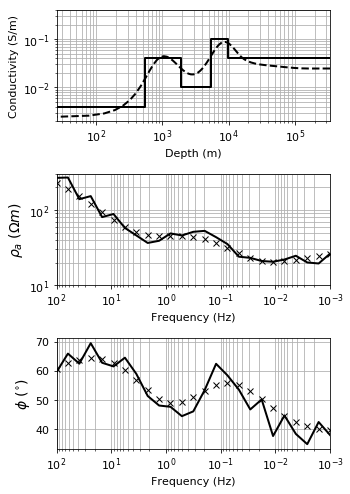

In [20]:
MT1D_inv_results(xc_smooth, -1)